# Profiling Notebooks

This notebook checks for the completeness and quality of the 1.25 million notebook files we have downloaded.

In [1]:
import os
import time
import json
import datetime
import requests
import shutil

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

## Get list of unique nbs we should have downloaded

In [4]:
df = pd.read_csv('../data/csv/nb_metadata.csv')
df.rename(columns = {'Unnamed: 0':'nb_id'}, inplace = True)
print(df.shape)
df.head()

(1253620, 16)


,nb_id,html_url,max_filesize,min_filesize,name,owner_html_url,owner_id,owner_login,path,query_page,repo_description,repo_fork,repo_html_url,repo_id,repo_name,repo_private
0,0,https://github.com/dalequark/emotivExperiment/...,10,0,EmotivDataAnalysis.ipynb,https://github.com/dalequark,2328571,dalequark,ipynb/EmotivDataAnalysis.ipynb,1,NaN,False,https://github.com/dalequark/emotivExperiment,26093748,emotivExperiment,False
1,1,https://github.com/kevcisme/madelon_redux/blob...,10,0,Part_IV_Project_3-checkpoint_BASE_63907.ipynb,https://github.com/kevcisme,24496260,kevcisme,ipynb/.ipynb_checkpoints/Part_IV_Project_3-che...,1,NaN,False,https://github.com/kevcisme/madelon_redux,95729593,madelon_redux,False
2,2,https://github.com/HaraldoFilho/DLND-Projects/...,10,0,_.ipynb,https://github.com/HaraldoFilho,15271881,HaraldoFilho,_.ipynb,1,"Index for the projects of the Udacity's ""Deep ...",False,https://github.com/HaraldoFilho/DLND-Projects,88182909,DLND-Projects,False
3,3,https://github.com/mhjensen/CPMLS/blob/4a5b37e...,10,0,csexmas2015.ipynb,https://github.com/mhjensen,2732953,mhjensen,doc/pub/CSETalks/csexmas2015/ipynb/csexmas2015...,1,Master program in Computational Science. The l...,False,https://github.com/mhjensen/CPMLS,35169104,CPMLS,False
4,4,https://github.com/freqn/atom_configuration/bl...,10,0,jupyter.ipynb,https://github.com/freqn,3611075,freqn,packages/file-icons/examples/jupyter.ipynb,1,Atom Config,False,https://github.com/freqn/atom_configuration,57460377,atom_configuration,False


First check that we have no duplicate notebook ids

In [5]:
df['nb_id'].value_counts().max()

1

## Check if we downloaded file for each notebook

Then check that we have a nb file for every notebook in here. For speed, we will want a sorted list of ints for the filenames to be able to compare our nb list to.

In [7]:
all_nbs = [f for f in os.listdir('../data/notebooks') if f.endswith('.ipynb')]
len(all_nbs)

1253620

This number matches the number of rows in our dataframe, so that is a good sign, now to compare the ids of the notebooks we downloaded with those in our dataframe.

In [8]:
# create sorted list of ints
all_nb_ints = [int(f.split('_')[1].split('.')[0]) for f in all_nbs]
all_nb_ints.sort()

In [9]:
def write_to_log(msg):
    f = '../logs/nb_cleaning_log.txt'
    log_file = open(f, "a")
    log_file.write(msg + "\n")
    log_file.close()

In [11]:
time1 = time.time()

offset = 0

for i, row in df.iterrows():
    if i % 100000 == 0:
        print('%s at %s' % (i, time.time() - time1))
        
    if all_nb_ints[i - offset] != row['nb_id']:
        msg = "nb %s not found" % row['nb_id']
        write_to_log(msg)
        offset += 1
        
time2 = time.time()
print(time2 - time1)
print('there were %s missing notebooks' % offset)

0 at 0.6025972366333008
100000 at 6.051319122314453
200000 at 11.501553297042847
300000 at 17.03659224510193
400000 at 22.630461931228638
500000 at 28.15279531478882
600000 at 33.680891275405884
700000 at 39.16721820831299
800000 at 44.61939096450806
900000 at 50.07477021217346
1000000 at 55.532562255859375
1100000 at 60.98104405403137
1200000 at 66.43209505081177
69.36901021003723
there were 0 missing notebooks


It appears we have a file for every nb we attempted to download!

## Check for files that did not download

Now we should check for files that did not download. This could be because they moved or were renamed. A reasonable check would be to look for files outside their expected size range. It could be that we are just missing files with an expected small bytes size (i.e. empty or malformatted files)

In [12]:
df['filesize'] = df.apply(lambda x: os.path.getsize('../data/notebooks/nb_%s.ipynb' % x['nb_id']), axis=1)

In [13]:
df['filesize_in_range'] = (np.logical_and(df['filesize'] <= df['max_filesize'], df['filesize'] >= df['min_filesize']))
df['filesize_in_range'].value_counts()

True     1246996
False       6624
Name: filesize_in_range, dtype: int64

In [18]:
df_out_of_range = df[~df['filesize_in_range']]

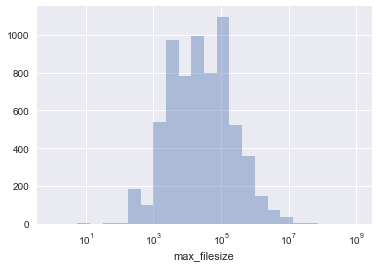

In [20]:
ax = sns.distplot(df_out_of_range['max_filesize'], kde=False, bins = np.logspace(0,9,25))
ax.set_xscale('log')

We have a healthy distribution here, meaning that we are missing files from all over the byte size spectrum. Let's look at a couple examples. My guess is we got 404 responses since the file moved.

In [22]:
f = '../data/notebooks/nb_%s.ipynb' % df_out_of_range.iloc[200]['nb_id']
with open(f, 'r') as nb_file:
    for l in nb_file:
        print(l)

404: Not Found



That is indeed the case. So it appears we are missing about 6,524 files here. This is not a large part of our sample, but still significant. We will not attempt to re-download these, assuming they were missing due to being renamed, moved, or deleted in the time between getting the notebook metadata from our Github API query, and actually trying to download the notebook files later.

That is it for checking the nb downloads. Now to download [metadata about their repos](4_repo_readme_metadata_download.ipynb).